# How to run a RL algorithm given a config file
- Step 1: Run ***python load_model.py --file config_file*** to generate python files based on which we can automatically generate a GYM environment;
- Step 2: Run ***python data_collection.py --env CSTR --algo MPC*** to collect data for training offline RL, where ***env*** and ***algo*** denote environment and algorithm to use, respectively.
- Step 3: Run ***python rl_training.py --env CSTR --algo CQL*** to train an offline RL policy
- Step 4: Run ***python algo_evaluation.py --plt --num_episodes 10 --env CSTR --algo CQL*** to evaluate the ***CQL*** policy for ***num_episodes*** rounds. Set ***plt*** to plot all results.

In [24]:
from algo_evaluation import evaluate_algorithms, OfflineRLModel
from mpc_policy import get_mpc_controller, MPCPolicy
import importlib
import pandas as pd
import os

algorithm_names = ["MPC", "CQL", "MOPO", "AWAC", "TD3PlusBC"]
algorithms = []
env_name = "CSTR"
num_episodes = 10

best_model_loc = f"./d3rlpy_logs/{env_name}/random_42"

if not os.path.exists(f"{best_model_loc}/results.csv"):
    env_lib = importlib.import_module(f"examples.{env_name}.template_env")
    env = env_lib.get_env()        
    for algo_name in algorithm_names:
        if algo_name == "MPC": algo = get_mpc_controller(env)
        else:
            algo = OfflineRLModel(algo_name, best_model_loc)
        algorithms.append((algo, algo_name))

    observations_list, actions_list, rewards_list = evaluate_algorithms(env, algorithms, num_episodes=num_episodes)

    df_data = []
    for n_algo, algo_name in enumerate(algorithm_names):
        for epi in range(num_episodes):
            for i in range(rewards_list.shape[-1]):
                df_data.append(observations_list[n_algo, epi, i].tolist() + actions_list[n_algo, epi, i].tolist() + [rewards_list[n_algo, epi, i], algo_name, epi, i])
    df = pd.DataFrame(data=df_data, columns=env.observation_name+env.action_name+["reward", "algo_name", "episode", "step"])
    df.to_csv(f"{best_model_loc}/results.csv", index=False)
else: 
    df = pd.read_csv(f"{best_model_loc}/results.csv", names=env.observation_name+env.action_name+["reward", "algo_name", "episode", "step"])

/anaconda/envs/env38/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [25]:
from ipywidgets import *
from vis_utility import layout_generator

children_dw = []
header = Button(
        description="Plot Configuraion",
        layout=Layout(width="auto", grid_area="header"),
        style=ButtonStyle(button_color="lightblue"),
    )

episode_dw = Dropdown(
            options=[0] + list(range(1, num_episodes+1)),
            value=0,
            description="Episode:",
        )

cols_dw = Dropdown(
            options=env.observation_name+env.action_name+["reward"],
            value=env.observation_name[0],
            description="Value:",
        )


children_dw.extend([episode_dw, cols_dw])

grid = layout_generator(header, children_dw, num_cols=1, col_width=400)
display(grid)

GridspecLayout(children=(Button(description='Plot Configuraion', layout=Layout(grid_area='widget001', width='a…

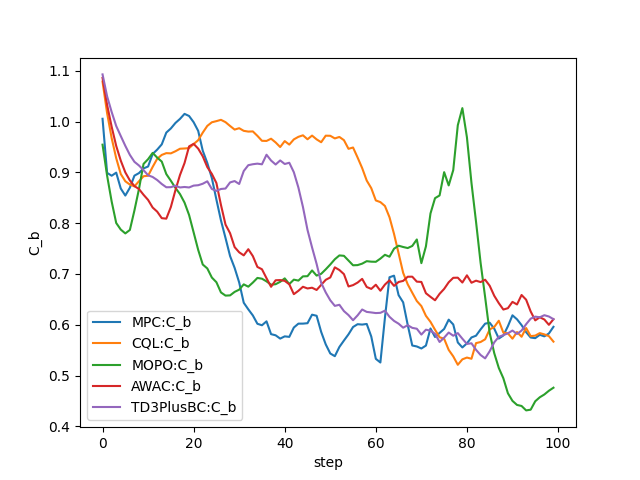

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
select_episode = episode_dw.value
col = cols_dw.value

if select_episode == 0:
    plot_df = df[["algo_name", "step"]+[col]].groupby(["algo_name", "step"]).mean().reset_index()
else: plot_df = df.loc[df["episode"] == select_episode, ["algo_name", "step"]+[col]]

fig, ax = plt.subplots()
for algo_name in algorithm_names:
    plot_df.loc[plot_df["algo_name"]==algo_name, :].plot('step', col, ax=ax, label=f"{algo_name}:{col}")
plt.xlabel("step")
plt.ylabel(col)
plt.show()
